<h1 style="text-align: center; color: #2c3e50;">
    Hate Speech Analysis in Tweets
</h1>
<hr style="height: 2px; border: none; background-color: #2c3e50;">

- Hate Speech in Tweets analysis consists of automatically identifying and classifying hate speech in Twitter posts. Using real data obtained from the *data.world* website, this study applies a sequential neural network model to perform the classification, differentiating between hate speech, attack language and neutrality. The analysis is part of the studies of the TAI - Topics in Artificial Intelligence class.

- A análise de Discurso de Ódio em tweets consiste em identificar e classificar automaticamente discursos de ódio em publicações no Twitter. Utilizando dados reais obtidos do site data.world, este estudo aplica um modelo de rede neural sequencial para realizar a classificação, diferenciando entre hate speech, linguagem ofensiva e neutra. A análise faz parte dos estudos da disciplina TIA - Tópicos em Inteligência Artificial.

<h2 style="color: #34495e;">
    Imported Libraries
</h2>
<hr style="height: 1px; border: none; background-color: #34495e;">

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

<h2 style="color: #34495e;">
    Dataset definition
</h2>
<hr style="height: 1px; border: none; background-color: #34495e;">

In [28]:
df = pd.read_csv('https://query.data.world/s/3w2odrweyv6zurbtbmxsxshcuwpwn3?dws=00000')

In [29]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [30]:
x = df.drop(columns=['class', 'Unnamed: 0'])
y = df['class']

In [31]:
x

,count,hate_speech,offensive_language,neither,tweet
0,3,0,0,3,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...
24778,3,0,2,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,youu got wild bitches tellin you lies


In [32]:
df['tweet_clean'] = df['tweet'].str.replace(r'[^A-Za-z\s]', '', regex=True).str.lower().str.strip()

In [33]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['tweet_clean'])

x_sequences = tokenizer.texts_to_sequences(df['tweet_clean'])
x_padded = pad_sequences(x_sequences, maxlen=100)

In [34]:
x_additional_features = df[['hate_speech', 'offensive_language', 'neither']].values
x_final = np.concatenate([x_padded, x_additional_features], axis=1)

In [35]:
x_tensor = tf.convert_to_tensor(x_final, dtype=tf.int32)
y_tensor = tf.convert_to_tensor(y.values, dtype=tf.int32)

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((x_tensor, y_tensor))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(103,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [37]:
train_size = int(0.8 * len(x))
test_size = len(x) - train_size

In [38]:
train_dataset = dataset.take(train_size)

In [39]:
test_dataset = dataset.skip(train_size)

In [40]:
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [41]:
print(f'Conjunto de treino: {train_size}')
print(f'Conjunto de teste: {test_size}')

Conjunto de treino: 19826
Conjunto de teste: 4957


<h2 style="color: #34495e;">
    Model definition
</h2>
<hr style="height: 1px; border: none; background-color: #34495e;">

In [43]:
model = models.Sequential()

model.add(layers.Dense(128, activation='relu', input_shape=(103,), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │          13,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,763 (85.01 KB)

 Trainable params: 21,763 (85.01 KB)

 Non-trainable params: 0 (0.00 B)

<h2 style="color: #34495e;">
    Model training
</h2>
<hr style="height: 1px; border: none; background-color: #34495e;">

In [45]:
class_weight = {0: 1., 1: 2., 2: 2.}

In [46]:
history = model.fit(train_dataset, epochs=15, validation_data=test_dataset, class_weight=class_weight)

Epoch 1/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5741 - loss: 376.6356 - val_accuracy: 0.7876 - val_loss: 1.1613
Epoch 2/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7159 - loss: 10.9168 - val_accuracy: 0.7924 - val_loss: 0.7779
Epoch 3/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7472 - loss: 3.2467 - val_accuracy: 0.7924 - val_loss: 0.7433
Epoch 4/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7564 - loss: 1.8672 - val_accuracy: 0.7924 - val_loss: 0.7352
Epoch 5/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7590 - loss: 1.6607 - val_accuracy: 0.7924 - val_loss: 0.7344
Epoch 6/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7624 - loss: 1.4448 - val_accuracy: 0.7924 - val_loss: 0.7347
Epoch 7/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7636 - loss: 1.3885 - val_accuracy: 0.7924 - val_loss: 0.7353
Epoch 8/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7648 - loss: 1.3850 - val_accuracy:

<h2 style="color: #34495e;">
    Model evaluation
</h2>
<hr style="height: 1px; border: none; background-color: #34495e;">

In [47]:
test_loss, test_acc = model.evaluate(test_dataset)

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7792 - loss: 0.7413


In [48]:
print(f"Perda no teste: {test_loss}")
print(f"Acurácia no teste: {test_acc}")

Perda no teste: 0.7260573506355286
Acurácia no teste: 0.7924147844314575


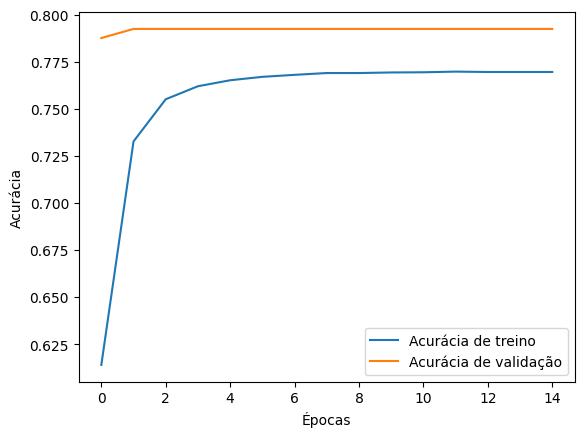

In [49]:
plt.plot(history.history['accuracy'], label='Acurácia de treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

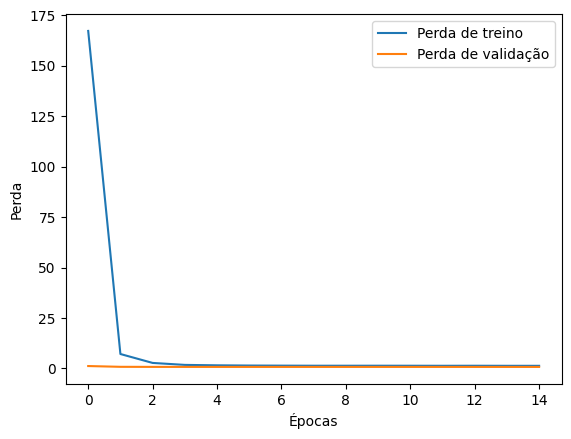

In [50]:
plt.plot(history.history['loss'], label='Perda de treino')
plt.plot(history.history['val_loss'], label='Perda de validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()